In [2]:
import numpy as np
from numpy import linalg

from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

import cvxopt
import cvxopt.solvers

def linear_kernel(x1, x2):
  return np.dot(x1, x2)

def polynomial_kernel(x, y, gamma = 1, r = 1, d = 3):
  return (r + gamma*np.dot(x, y)) ** d

def gaussian_kernel(x, y, sigma= 5.0):
  return np.exp(-linalg.norm(x-y)**2 / (2*(sigma ** 2)))

In [3]:
class SVM(object):
  
  def __init__(self, kernel=linear_kernel, C=None):
    self.kernel = kernel
    self.C = C
    if self.C is not None: self.C = float(self.C)

  def fit(self, X, y):
    n_samples, n_features = X.shape

    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
      for j in range(n_samples):
        K[i,j] = self.kernel(X[i], X[j])

    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1,n_samples))
    b = cvxopt.matrix(0.0)

    if self.C is None:
      G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
      h = cvxopt.matrix(np.zeros(n_samples))
    else:
      tmp1 = np.diag(np.ones(n_samples) * -1)
      tmp2 = np.identity(n_samples)
      G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
      tmp1 = np.zeros(n_samples)
      tmp2 = np.ones(n_samples) * self.C
      h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

    # solve QP problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Lagrange multipliers a = \lambda
    a = np.ravel(solution['x'])

    # Support vectors have non zero lagrange multipliers
    sv = a > 1e-5
    ind = np.arange(len(a))[sv]
    self.a = a[sv]
    self.sv = X[sv]
    self.sv_y = y[sv]
    print("%d support vectors out of %d points" % (len(self.a), n_samples))

    # Intercept
    self.b = 0
    for n in range(len(self.a)):
      self.b += self.sv_y[n]
      self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
    self.b /= len(self.a)

    if self.kernel == linear_kernel:
      self.w = np.zeros(n_features)
      for n in range(len(self.a)):
        self.w += self.a[n] * self.sv_y[n] * self.sv[n]
    else:
      self.w = None

  def project(self, X):
    if self.w is not None:
      return np.dot(X, self.w) + self.b
    else:
      y_predict = np.zeros(len(X))
      for i in range(len(X)):
        s = 0
        for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
          s +=  a * sv_y * self.kernel(X[i], sv)
        y_predict[i] = s
        return y_predict + self.b

  def predict(self, X):
    return np.sign(self.project(X))

if __name__ == "__main__":
  import pylab as pl

  def gen_circle_data():
    # Generate dataset and targets
    X, Y = make_circles(n_samples = 200, noise = 0.02)
    X1 = 4.0*X[Y==1, :]
    X2 = 4.0*X[Y==0, :]
    y1 = np.ones(len(X1))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2  

  def gen_lin_separable_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[0.8, 0.6], [0.6, 0.8]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

  def gen_non_lin_separable_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

  def gen_lin_separable_overlap_data():
    # generate training data in the 2-d case
    mean1 = np.array([0, 2])
    mean2 = np.array([2, 0])
    cov = np.array([[1.5, 1.0], [1.0, 1.5]])
    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

  def split_train(X1, y1, X2, y2):
    X1_train = X1[:90]
    y1_train = y1[:90]
    X2_train = X2[:90]
    y2_train = y2[:90]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train 

  def split_test(X1, y1, X2, y2):
    X1_test = X1[90:]
    y1_test = y1[90:]
    X2_test = X2[90:]
    y2_test = y2[90:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

  def plot_margin(X1_train, X2_train, clf):
    def f(x, w, b, c=0):
    # given x, return y such that [x,y] in on the line
    # w.x + b = c
      return (-w[0] * x - b + c) / w[1]

    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    # w.x + b = 0
    a0 = -4; a1 = f(a0, clf.w, clf.b)
    b0 = 4; b1 = f(b0, clf.w, clf.b)
    pl.plot([a0,b0], [a1,b1], "k")

    # w.x + b = 1
    a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
    pl.plot([a0,b0], [a1,b1], "k--")

    # w.x + b = -1
    a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
    b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
    pl.plot([a0,b0], [a1,b1], "k--")

    pl.axis("tight")
    pl.show()
  
  def plot_contour(X1_train, X2_train, clf):
    pl.plot(X1_train[:,0], X1_train[:,1], "ro")
    pl.plot(X2_train[:,0], X2_train[:,1], "bo")
    pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

    X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.project(X).reshape(X1.shape)
    pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
    pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

    pl.axis("tight")
    pl.show()

  def test_linear():
    X1, y1, X2, y2 = gen_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM()
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_margin(X_train[y_train==1], X_train[y_train==-1], clf)
  
  def test_non_linear():
    X1, y1, X2, y2 = gen_circle_data()
    #X1, y1, X2, y2 = gen_non_lin_separable_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    #clf = SVM(polynomial_kernel)
    clf = SVM(gaussian_kernel)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)

  def test_soft():
    X1, y1, X2, y2 = gen_lin_separable_overlap_data()
    X_train, y_train = split_train(X1, y1, X2, y2)
    X_test, y_test = split_test(X1, y1, X2, y2)

    clf = SVM(C=1000.1)
    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    correct = np.sum(y_predict == y_test)
    print("%d out of %d predictions correct" % (correct, len(y_predict)))

    plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)


     pcost       dcost       gap    pres   dres
 0: -9.5865e+01 -2.3599e+02  1e+02  2e-14  2e+00
 1: -1.3292e+02 -1.8760e+02  5e+01  2e-14  8e-01
 2: -1.6806e+02 -2.2797e+02  6e+01  9e-15  8e-01
 3: -2.7552e+02 -3.5436e+02  8e+01  3e-14  7e-01
 4: -4.3792e+02 -5.3484e+02  1e+02  5e-14  4e-01
 5: -4.7811e+02 -5.1937e+02  4e+01  1e-13  6e-02
 6: -4.9205e+02 -4.9396e+02  2e+00  1e-13  2e-03
 7: -4.9279e+02 -4.9281e+02  2e-02  1e-13  3e-05
 8: -4.9280e+02 -4.9280e+02  2e-04  1e-13  3e-07
 9: -4.9280e+02 -4.9280e+02  2e-06  9e-14  3e-09
Optimal solution found.
8 support vectors out of 180 points
11 out of 20 predictions correct


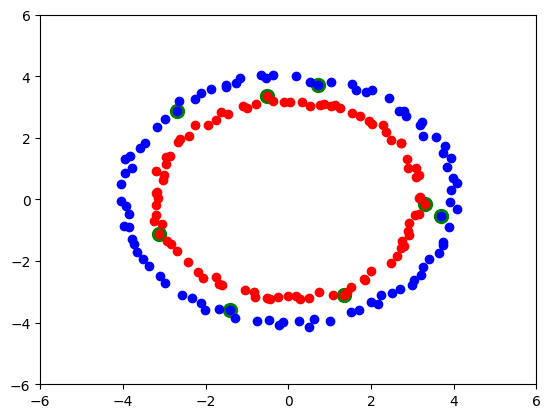

In [4]:
test_non_linear()

     pcost       dcost       gap    pres   dres
 0: -1.7122e+01 -3.4343e+01  6e+02  2e+01  2e+00
 1: -2.4467e+01 -2.5454e+01  3e+02  1e+01  9e-01
 2: -6.3066e+01 -5.0433e+01  3e+02  8e+00  7e-01
 3: -2.6967e+02 -1.7443e+02  3e+02  7e+00  6e-01
 4: -5.5419e+01 -2.9694e+01  2e+02  2e+00  2e-01
 5: -1.4183e+01 -1.9116e+01  5e+00  2e-14  6e-14
 6: -1.6959e+01 -1.7039e+01  8e-02  7e-15  3e-14
 7: -1.7016e+01 -1.7017e+01  8e-04  1e-14  3e-14
 8: -1.7017e+01 -1.7017e+01  8e-06  7e-15  4e-14
Optimal solution found.
3 support vectors out of 180 points
20 out of 20 predictions correct


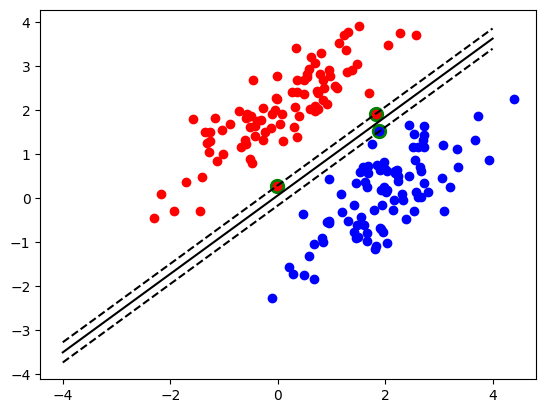

In [5]:
test_linear()

     pcost       dcost       gap    pres   dres
 0:  1.4337e+05 -9.5643e+07  2e+08  6e-01  7e-12
 1:  4.1715e+05 -2.0195e+07  3e+07  6e-02  2e-11
 2:  4.0921e+05 -3.1816e+06  5e+06  8e-03  4e-12
 3:  9.8209e+04 -3.8433e+05  5e+05  5e-13  2e-12
 4:  1.4697e+03 -4.8913e+04  5e+04  1e-12  1e-12
 5: -2.7466e+03 -8.6561e+03  6e+03  9e-13  1e-12
 6: -3.2707e+03 -8.3795e+03  5e+03  1e-12  1e-12
 7: -4.2424e+03 -8.5281e+03  4e+03  7e-13  2e-12
 8: -3.8335e+03 -8.1186e+03  4e+03  1e-12  1e-12
 9: -4.4286e+03 -8.0599e+03  4e+03  1e-12  1e-12
10: -4.1980e+03 -7.8229e+03  4e+03  1e-12  1e-12
11: -5.0488e+03 -7.1147e+03  2e+03  3e-13  2e-12
12: -5.7579e+03 -6.2275e+03  5e+02  8e-13  2e-12
13: -5.9237e+03 -5.9383e+03  1e+01  2e-12  3e-12
14: -5.9269e+03 -5.9303e+03  3e+00  1e-12  2e-12
15: -5.9281e+03 -5.9289e+03  8e-01  9e-13  2e-12
16: -5.9283e+03 -5.9287e+03  5e-01  2e-12  2e-12
17: -5.9285e+03 -5.9285e+03  5e-03  2e-12  3e-12
Optimal solution found.
10 support vectors out of 180 points
20 out of

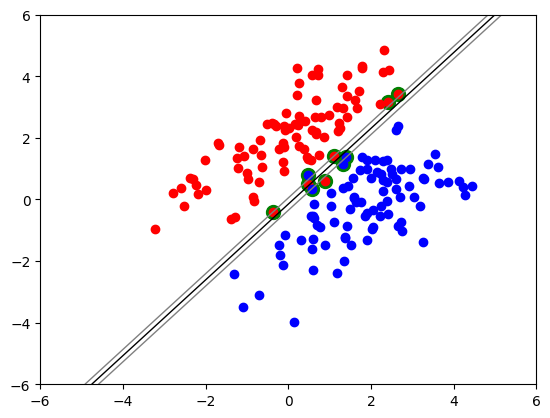

In [6]:
test_soft()

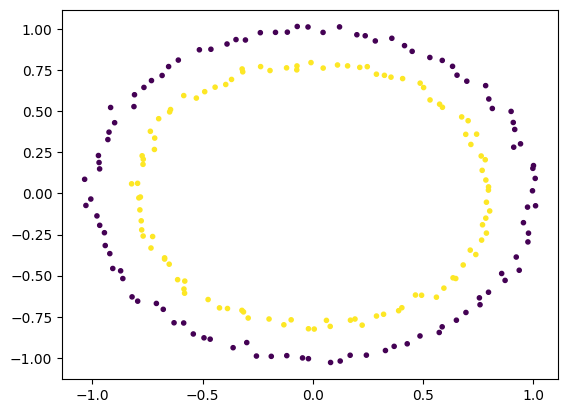

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from matplotlib.backends.backend_pdf import  PdfPages
from sklearn.datasets import make_circles

X, Y = make_circles(n_samples=200, noise = 0.02)

plt.scatter(X[:, 0], X[:, 1], c = Y, marker = '.')
plt.show()

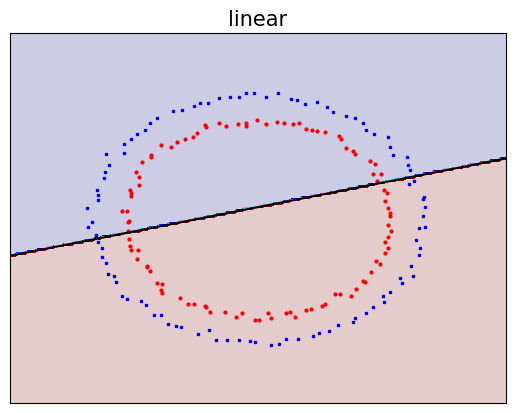

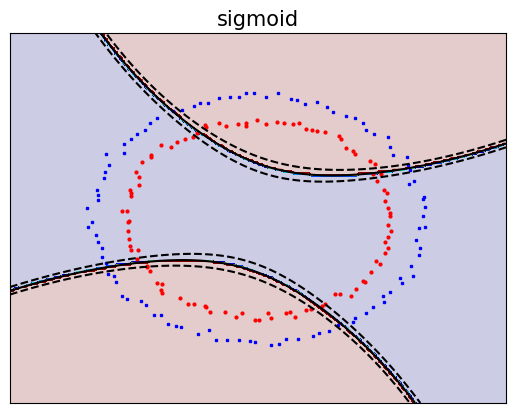

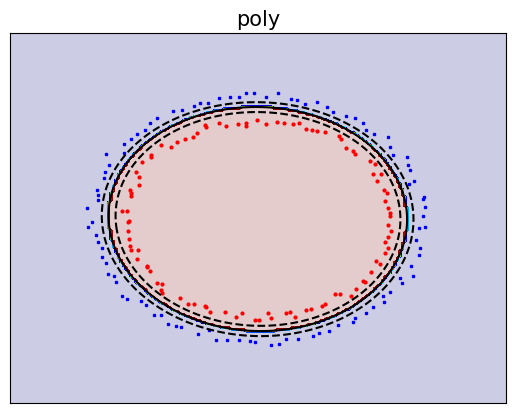

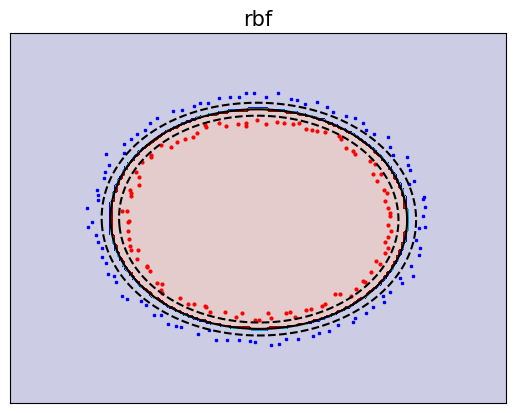

In [8]:
fignum = 1

for kernel in ('linear', 'sigmoid', 'poly', 'rbf'):
  clf = svm.SVC(kernel=kernel, gamma = 1, coef0=1)
  clf.fit(X, Y)
  with PdfPages(kernel + '3.pdf') as pdf:
    fig, ax = plt.subplots()
    plt.figure(fignum, figsize=(5,5))
    plt.clf()

    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:,1], s =80,
                facecolors = 'None')
    plt.plot(X[Y==0, 0], X[Y==0,1], 'bs', markersize = 2)
    plt.plot(X[Y==1, 0], X[Y==1, 1], 'ro', markersize = 2)

    plt.axis('tight')
    x_min = -1.5
    x_max = 1.5
    y_min = -1.5
    y_max = 1.5
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(5, 5))
    CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
    levels=[-.5, 0, .5])
    plt.title(kernel, fontsize = 15)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
    pdf.savefig()
plt.show()